# Institute for Behavioral Genetics International Statistical Genetics 2023 Workshop 

# Rare Variant Analysis of Sequencing Data with Hail

Learning objectives:

1. Understand statistical models of rare variant effects on phenotype.
2. Understand how to use Hail to perform a Burden test.
3. Understand how to use Hail to perform a SKAT test.

## Theory

The phrase "genome-wide association study" (GWAS) usually refers to independently testing every variant in a dataset against a phenotype. For a continuous phenotype, we symbolically state that as:

$$
\begin{align*}
N &: \mathbb{N} &\textrm{The number of samples} \\
M &: \mathbb{N} &\textrm{The number of variants} \\
G &: \{0, 1, 2\}^{N \times M} &\textrm{The genotypes represented as the number of alternate alleles} \\
y &: \mathbb{R}^{N} &\textrm{The value of the phenotype for each sample}\\
\beta &: \mathbb{R}^{M} &\textrm{The unknown effect of each variant on the phenotype}\\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) &\textrm{Normally distributed measurement error of unknown variance, }\sigma^2\\
y_i &= \beta_j G_{ij} + \varepsilon_i
\end{align*}
$$

This model lacks sufficient statistical power to detect rare variants _because of_ their rarity. There are two ways to address this problem: collect more samples or combine multiple variants into a single association test. In this notebook, we explore two tests for combining multiple variants: the burden test and the squence kernel association test (SKAT).

The burden test considers the sum of effects of a set of variants on a phenotype. When the set of variants is a gene, this test is called a gene burden set. Analagously to testing every variant in GWAS, we typically test many variant-sets. We symbolically state this model as:

$$
\begin{align*}
S_k && \textrm{The } k\textrm{-th set of variants} \\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= \beta_k \left( \sum_{j \in S_k} G_{ij} \right) + \varepsilon_i
\end{align*}
$$

This model is well-powered for rare variants whose effects have the same direction. For example, if all the variants in a gene increase the chance of disease, a burden test is well-powered. If the direction of effect of variants in the set is random and the effects size are all of similar magnitude, the sum of effects will trend towards zero. We can simulate and visualize this effect:

In [1]:
%config InlineBackend.figure_format = 'retina'

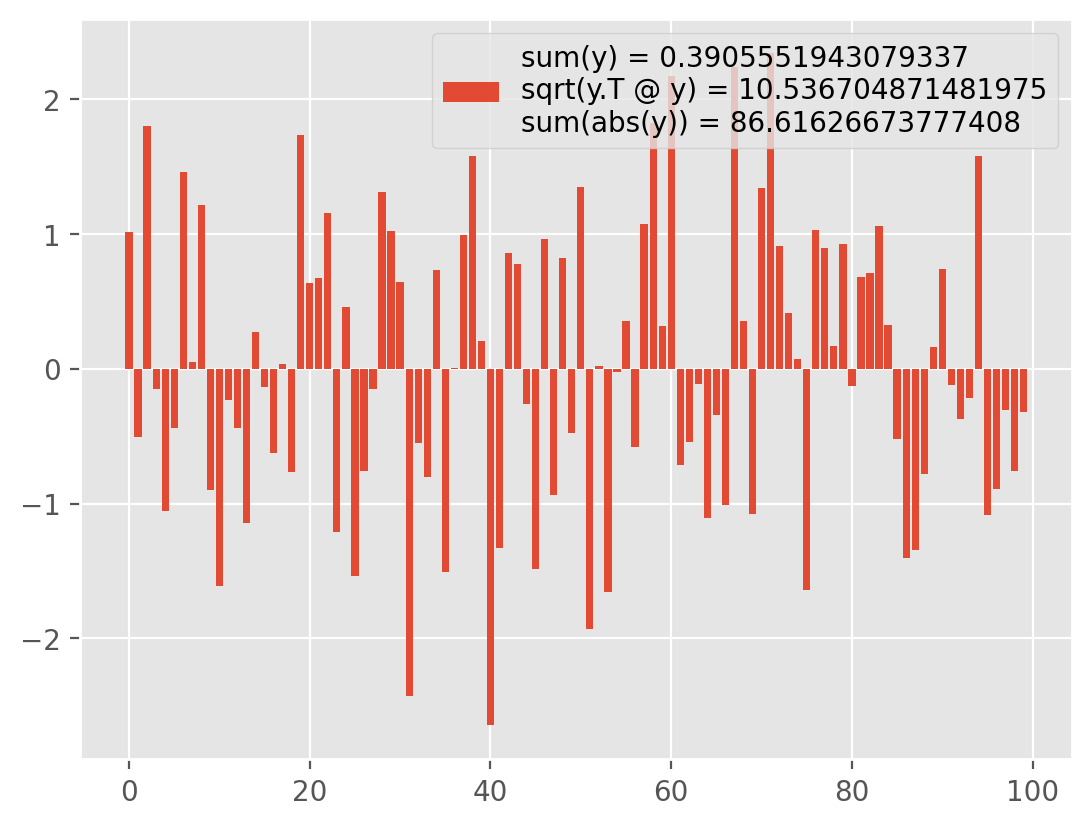

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

effects = np.random.normal(0, 1, size=100)

sum_of_effects = np.sum(effects)
magnitude_of_effects = np.sqrt(effects.T @ effects)
sum_of_abs_of_effects = np.sum(np.abs(effects))

plt.bar(list(range(100)), effects,
        label=(f'sum(y) = {sum_of_effects}\n'
               f'sqrt(y.T @ y) = {magnitude_of_effects}\n'
               f'sum(abs(y)) = {sum_of_abs_of_effects}'))
plt.legend(loc='upper right')
plt.show()

If we can confidently predict the directions of effects (while the effect sizes themselves are still unknown), we can encode that knowledge as a "weight". A burden test with weights is known as a weighted burden test. We symbolically represent it as:

$$
\begin{align*}
S_k && \textrm{The } k\textrm{-th set of variants} \\
w &: \mathbb{R}^M &\textrm{The weights for each variant}\\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= \beta_k \left( \sum_{j \in S_k} w_j G_{ij} \right) + \varepsilon_i
\end{align*}
$$


If we do not know the directions of effects, we can instead test for excess variance of the effect sizes of a set of variants. The sequence kernel association test (SKAT) is one such test. It does not report an effect size because it does not test the strength of the association. Instead, SKAT reports a $p$-value of rejecting its null hypothesis: that the effect of the genotypes on the phenotypes is zero. The SKAT test involves two models, a null model and a full model. Both models include a set of covariates per sample. The full model is:

$$
\begin{align*}
K && \textrm{The number of covariates} \\
X &: \mathbb{R}^{N \times K} &\textrm{The covariates for each sample} \\
\\
\varepsilon_i &\sim \mathcal{N}(0, \sigma^2) \\
y_i &= X \vec{\alpha} + G \vec{\beta} + \varepsilon_i
\end{align*}
$$

The null model considers only the covariates:

$$
\begin{align*}
y_i &= X \vec{\alpha}_{\textrm{null}} + \varepsilon_i
\end{align*}
$$

The null hypothesis supposes that $\beta = 0$. The test of the null hypothesis essentially investigates the likelihood that the residual variance (i.e. $y - X \widehat{\vec{\alpha}_{\textrm{null}}}$) is truly independently, identically, and normally distributed noise. The details of how to test that are somewhat complex and involve a distribution without a closed form. We refer the interested reader to the [SKAT paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3135811/).

### Setup

Import Hail and configure the plotting system for Notebooks.

In [3]:
import hail as hl

In [4]:
hl.plot.output_notebook()

Loading BokehJS ...

## The Burden Test
### Step 1: Quality Control & Sample Annotation

The last notebook covered these steps in detail. We'll do them quickly here:

In [5]:
# read matrix from disk; this was written from the imported VCF in the common variant practical
mt = hl.read_matrix_table('resources/hgdp-tgp-rare-variants.mt')

# import annotations
sd = hl.import_table('resources/HGDP_sample_data.tsv',
                     key='sample_id',
                     impute=True)

# annotate columns
mt = mt.annotate_cols(sample_data = sd[mt.s])

# remove non-PASS variants
mt = mt.filter_rows(hl.len(mt.filters) == 0)

Initializing Hail with default parameters...


23/02/27 15:28:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://wm28c-761:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.109-3cd6e4b2986e
LOGGING: writing to /Users/dking/projects/2021_IBG_Hail/hail-20230227-1528-0.2.109-3cd6e4b2986e.log


#### Remove Common Variants

Next, we will keep variants with an allele frequency of under 1%. Including common variants will only reduce the power of a burden test.

We could rerun `hl.variant_qc` here, or use an aggregator designed to compute allele frequencies and counts:

In [6]:
mt = mt.filter_rows(
    hl.agg.call_stats(mt.GT, mt.alleles).AF[1] < 0.01
)

We also remove variants without any non-reference calls:

In [7]:
mt = mt.filter_rows(
    hl.agg.all(mt.GT.is_hom_ref()),
    keep=False
)

### Step 2: Group by gene


In [8]:
genes = hl.read_table('resources/genes.ht')

In [9]:
genes.show()

,
interval,gene_name
interval<locus<GRCh38>>,str
[chr1:11869-chr1:14409],"""DDX11L1"""
[chr1:14404-chr1:29570],"""WASH7P"""
[chr1:17369-chr1:17436],"""MIR6859-1"""
[chr1:29554-chr1:31109],"""MIR1302-2HG"""
[chr1:30366-chr1:30503],"""MIR1302-2"""
[chr1:34554-chr1:36081],"""FAM138A"""
[chr1:52473-chr1:53312],"""OR4G4P"""
[chr1:57598-chr1:64116],"""OR4G11P"""


#### Exercise

# FIXME: new exercise?

Use the `aggregate` method and the familiar `hl.agg.counter` aggregator to compute the number of appearances of each "csq" value.

Which of these would you expect to have no effect on a protein? Which would you expect to have a large effect?

#### Annotate variants with genes

In order join our two tables (the QC-ed data and gene table), we need to create fields of type `locus` and `array<str>` (alleles) to match the row key of our matrix.

We can use the `hl.parse_variant` function to parse the `variant` field of this table of `CHR:POS:REF:ALT` form to a locus and alleles array. Then we assign these new fields to be the key:


In [10]:
#parsed = hl.parse_variant(annotation_ht.variant, reference_genome='GRCh38')
#annotation_ht = annotation_ht.key_by(locus = parsed.locus, alleles=parsed.alleles).drop('variant')

Recall how we annotated sample phenotypes earlier in the common variant tutorial -- this join looks very similar:

In [11]:
mt = mt.annotate_rows(gene_name = genes[mt.locus].gene_name)

In [12]:
mt = hl.variant_qc(mt)

rand_sign = (hl.rand_bool(0.5) * 2 - 1)

mt = mt.annotate_rows(
    pheno1_true_effect = hl.if_else(
        mt.gene_name == "MREG",
        5,
        0),
    pheno2_true_effect = hl.if_else(
        mt.gene_name == "KLHL5",
        rand_sign / (mt.variant_qc.AF[1] * 1000),
        0),
)

mt = mt.annotate_cols(
    pheno1 = hl.agg.sum(mt.pheno1_true_effect * mt.GT.n_alt_alleles()) + hl.rand_norm(0, 20),
    pheno2 = hl.agg.sum(mt.pheno2_true_effect * mt.GT.n_alt_alleles()) + hl.rand_norm(0, 2.5)
)

Let's `show` the resulting annotations on the matrix table to make sure everything worked:

In [13]:
mt.gene_name.show()

,,
locus,alleles,gene_name
locus<GRCh38>,array<str>,str
chr1:949490,"[""G"",""A""]","""NOC2L"""
chr1:950316,"[""G"",""A""]","""NOC2L"""
chr1:950751,"[""C"",""T""]","""NOC2L"""
chr1:951750,"[""G"",""A""]","""NOC2L"""
chr1:952412,"[""C"",""T""]","""NOC2L"""
chr1:953543,"[""G"",""A""]","""NOC2L"""
chr1:953730,"[""G"",""A""]","""NOC2L"""
chr1:954116,"[""C"",""G""]","""NOC2L"""


### Step 3: Aggregate by gene

Hail's modularity makes it easy to perform non-kernel-based burden tests.

We'll compose two general tools:
 - [group_rows_by](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable.group_rows_by) / [aggregate](https://hail.is/docs/0.2/hail.GroupedMatrixTable.html#hail.GroupedMatrixTable.aggregate)
 - [hl.linear_regression_rows](https://hail.is/docs/0.2/methods/stats.html#hail.methods.linear_regression_rows).
 
This means that you can flexibly specify the way genotypes are summarized per gene. Using other tools, you may have a few ways to aggregate, but if you want to do something different you are out of luck!

In [14]:
burden_mt = mt.group_rows_by(mt.gene_name).aggregate(
    n_variants = hl.agg.count_where(mt.GT.n_alt_alleles() > 0)
)

# filter to genes with at least one rare variant!
burden_mt = burden_mt.filter_rows(hl.agg.sum(burden_mt.n_variants) > 0)

In [15]:
burden_mt.describe(widget=True)

In [16]:
burden_mt.show(n_cols=5, n_rows=5)

,,,,,
,'CHMI_CHMI3_WGS2','LP6005441-DNA_F08','HGDP00843','HGDP00392','LP6005441-DNA_H03'
gene_name,n_variants,n_variants,n_variants,n_variants,n_variants
str,int64,int64,int64,int64,int64
"""AC003044.1""",0,0,0,1,0
"""AC005014.1""",0,0,0,0,0
"""AC005599.1""",0,0,0,0,0
"""AC006296.3""",0,0,0,0,0
"""AC007161.3""",0,0,0,0,0


#### Exercise

Is this a dense (mostly non-zero) or sparse (mostly zero) matrix? Is this expected? How many variants are in our dataset, and how many genes are there?

### Step 4: Run linear regression per gene

This should look familiar! We can reuse the same modular components (like `linear_regression_rows`) for many different purposes.

In [17]:
_, pca_scores, _ = hl.hwe_normalized_pca(mt.GT)

In [18]:
burden_mt = burden_mt.annotate_cols(pca = pca_scores[burden_mt.s])

burden_results = hl.linear_regression_rows(
    y=burden_mt.pheno1, 
    x=burden_mt.n_variants,
    covariates=[1.0, 
                burden_mt.pca.scores[0], 
                burden_mt.pca.scores[1], 
                burden_mt.pca.scores[2]])

We use Hail's new plotting system, `hl.ggplot`, to show a bar graph of the burden results. The genes are sorted alphabetically, not by genomic location.

In [19]:
from hail.ggplot import *
import plotly
import plotly.io as pio
pio.renderers.default='iframe'

ht = burden_results
ggplot(ht) + geom_col(aes(x=ht.gene_name, y=-hl.log(ht.p_value, base=10)))

We can also look at the first ten results in ascending order of p-value.

In [20]:
burden_results.order_by(burden_results.p_value).show()

,,,,,,,
gene_name,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
str,int32,float64,float64,float64,float64,float64,float64
"""MREG""",4151,2.36e+02,1.26e+03,5.38e+00,1.29e+00,4.17e+00,3.11e-05
"""TFB2M""",4151,1.44e+02,7.31e+02,5.07e+00,1.68e+00,3.03e+00,2.48e-03
"""AC131235.2""",4151,2.00e+00,7.11e+01,3.58e+01,1.42e+01,2.53e+00,1.15e-02
"""EGLN1""",4151,1.56e+02,6.24e+02,4.18e+00,1.66e+00,2.51e+00,1.20e-02
"""TLCD4""",4151,6.00e+01,3.35e+02,5.49e+00,2.57e+00,2.14e+00,3.27e-02
"""LINC02591""",4151,1.00e+00,4.21e+01,4.22e+01,2.00e+01,2.11e+00,3.50e-02
"""NOC2L""",4151,3.60e+01,-2.35e+02,-6.86e+00,3.31e+00,-2.07e+00,3.84e-02
"""LINC01397""",4151,1.43e+02,4.63e+02,3.36e+00,1.72e+00,1.95e+00,5.13e-02


Finally, a Q-Q plot is meaningful on genes. Let's plot one:

In [21]:
p = hl.plot.qq(burden_results.p_value)
hl.plot.show(p)

With fewer tests performed (one per gene, instead of one per variant), the X and Y range of the Q-Q plot is much smaller than in the common variant association practical.

This plot is showing us that although our study is relatively well-controlled, it's also very underpowered!

## The Sequence Kernel Association Test (SKAT)

The sequence kernel association test is one of Hail's built-in methods. The SKAT paper suggests using weights taken from the CDF of a 1,25-Beta distribution evaluated at the allele frequency of the variant.

In [22]:
skat_mt = mt
skat_mt = skat_mt.annotate_cols(
    pca = pca_scores[skat_mt.s]
)
skat_mt = hl.variant_qc(skat_mt)
skat_mt = skat_mt.annotate_rows(
    weight = hl.dbeta(skat_mt.variant_qc.AF[1], 1, 25)
)

skat_results = hl.skat(
    skat_mt.gene_name,
    skat_mt.weight,
    y = skat_mt.pheno2, 
    x = skat_mt.GT.n_alt_alleles(),
    covariates = [1.0, 
                  skat_mt.pca.scores[0], 
                  skat_mt.pca.scores[1], 
                  skat_mt.pca.scores[2]]
)

In [23]:
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'gene_name': str 
    'n': int32 
    'sum_x': float64 
    'y_transpose_x': float64 
    'beta': float64 
    'standard_error': float64 
    't_stat': float64 
    'p_value': float64 
----------------------------------------
Key: ['gene_name']
----------------------------------------


In [24]:
ht = skat_results
ht = ht.annotate(
    p_value = hl.if_else(ht.fault == 0, ht.p_value, 1)
)
ggplot(ht) + geom_col(aes(x=ht.id, y=-hl.log(ht.p_value, base=10)))

In [25]:
skat_results.order_by(skat_results.p_value).show()

,,,,
id,size,q_stat,p_value,fault
str,int32,float64,float64,int32
"""KLHL5""",25,7.96e+03,9.41e-05,0
"""SFT2D2""",11,6.31e+03,5.60e-03,0
"""TLCD4""",9,2.52e+03,1.21e-02,0
"""TLCD4-RWDD3""",21,4.64e+03,1.41e-02,0
"""WDR35""",31,6.82e+03,1.47e-02,0
"""DUX4""",22,5.12e+03,2.80e-02,0
"""FBLIM1""",16,8.36e+02,5.14e-02,0
"""AC055764.2""",1,4.65e+01,5.35e-02,0


We can compre against the linear models. In both the case of pheno1 and pheno2, the linear models fail to find a statistically significant association. Notice that there are many variants that happen to be correlated with our randomly generated phenotypes! Since we've run thousands of tests, any individual test must have an exceedingly small p-value to convince us of its validity. Alas, the regions of the genome associated with these two do not rise above the noise.

In [26]:
genes.filter(hl.set(['MREG', 'KLHL5']).contains(genes.gene_name)).show()

,
interval,gene_name
interval<locus<GRCh38>>,str
[chr2:215942584-chr2:216034096],"""MREG"""
[chr4:39045039-chr4:39126857],"""KLHL5"""


In [27]:
mt = mt.annotate_cols(pca = pca_scores[mt.s])


linreg_results = hl.linear_regression_rows(
    y=mt.pheno1, 
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, 
                mt.pca.scores[0], 
                mt.pca.scores[1], 
                mt.pca.scores[2]])
ht = linreg_results
hl.plot.show(hl.plot.manhattan(ht.p_value))
linreg_results.order_by(linreg_results.p_value).show()

,,,,,,,,
locus,alleles,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
locus<GRCh38>,array<str>,int32,float64,float64,float64,float64,float64,float64
chr2:216026821,"[""A"",""G""]",4151,7.00e+01,7.38e+02,1.08e+01,2.41e+00,4.48e+00,7.59e-06
chr1:95163286,"[""C"",""T""]",4151,9.00e+00,2.29e+02,2.56e+01,6.67e+00,3.83e+00,1.29e-04
chr1:61872068,"[""A"",""G""]",4151,2.00e+00,1.01e+02,5.07e+01,1.41e+01,3.59e+00,3.40e-04
chr7:117738954,"[""G"",""A""]",4151,1.00e+00,7.11e+01,7.11e+01,2.00e+01,3.56e+00,3.81e-04
chr6:143088243,"[""G"",""A""]",4151,1.01e+00,7.11e+01,7.11e+01,2.00e+01,3.56e+00,3.82e-04
chr6:143251809,"[""C"",""T""]",4151,1.00e+00,7.05e+01,7.06e+01,2.00e+01,3.53e+00,4.17e-04
chr5:156232994,"[""G"",""A""]",4151,1.00e+00,-6.96e+01,-6.94e+01,2.00e+01,-3.47e+00,5.29e-04
chr5:156431319,"[""A"",""G""]",4151,4.00e+01,4.37e+02,1.07e+01,3.10e+00,3.44e+00,5.87e-04


In [28]:
mt = mt.annotate_cols(pca = pca_scores[mt.s])

linreg_results = hl.linear_regression_rows(
    y=mt.pheno2, 
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, 
                mt.pca.scores[0], 
                mt.pca.scores[1], 
                mt.pca.scores[2]])
ht = linreg_results
hl.plot.show(hl.plot.manhattan(ht.p_value))
linreg_results.order_by(linreg_results.p_value).show()

,,,,,,,,
locus,alleles,n,sum_x,y_transpose_x,beta,standard_error,t_stat,p_value
locus<GRCh38>,array<str>,int32,float64,float64,float64,float64,float64,float64
chr4:39099054,"[""G"",""T""]",4151,1.00e+00,1.21e+01,1.22e+01,2.54e+00,4.79e+00,1.76e-06
chr7:130881591,"[""C"",""A""]",4151,1.00e+00,1.21e+01,1.22e+01,2.54e+00,4.79e+00,1.76e-06
chr4:39123752,"[""C"",""T""]",4151,1.00e+00,1.15e+01,1.15e+01,2.54e+00,4.52e+00,6.45e-06
chr4:4193655,"[""T"",""C""]",4151,1.00e+00,1.15e+01,1.15e+01,2.54e+00,4.52e+00,6.46e-06
chr4:10628077,"[""C"",""A""]",4151,1.00e+00,-1.13e+01,-1.13e+01,2.54e+00,-4.45e+00,8.78e-06
chr4:39077705,"[""A"",""C""]",4151,1.01e+00,-1.13e+01,-1.13e+01,2.54e+00,-4.45e+00,8.91e-06
chr5:156597958,"[""G"",""C""]",4151,1.00e+00,-9.28e+00,-1.09e+01,2.63e+00,-4.16e+00,3.29e-05
chr1:51781907,"[""G"",""A""]",4151,1.00e+00,-9.28e+00,-1.09e+01,2.63e+00,-4.16e+00,3.29e-05
